In [1]:
# conda create --name tf_cpu_bert_seq --file ./assets/requirements_tf_cpu_bert_seq_model.txt

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

from pathlib import Path
k_Current_dir = Path.cwd()
k_AssetsDir = "assets"
k_sms_max_len = 100
k_random_state  = 42
k_test_size     = 0.3
k_batch_size = 32




c:\Users\phili\anaconda3\envs\tf_cpu_bert_seq\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "labels"}, inplace=True)
    df.rename(columns={"v2": "texts"}, inplace=True)

    df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

    return df

In [3]:
def convert_data_to_examples(texts, labels):
    examples = []
    for text, label in zip(texts, labels):
        examples.append(InputExample(guid=None, text_a=text, text_b=None, label=label))
    return examples


In [4]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=k_sms_max_len):
    features = []

    for example in examples:
        input_dict = tokenizer.encode_plus(
            example.text_a,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )
        input_ids, attention_mask = input_dict["input_ids"], input_dict["attention_mask"]

        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                label=example.label
            )
        )

    def gen():
        for feature in features:
            yield (
                {
                    'input_ids': feature.input_ids,
                    'attention_mask': feature.attention_mask
                },
                feature.label
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({'input_ids': tf.int32, 'attention_mask': tf.int32}, tf.int64),
        ({'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None])}, tf.TensorShape([])),
    )


c:\Users\phili\anaconda3\envs\tf_cpu_bert_seq\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 24,429,314
Non-trainable params: 85,054,464
_________________________________________________________________


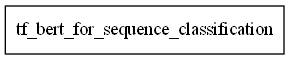

In [5]:
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
df = cleaner(df)

X = df['texts'].values
y = df['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_examples = convert_data_to_examples(X_train, y_train)
test_examples  = convert_data_to_examples(X_test, y_test)

train_dataset = convert_examples_to_tf_dataset(train_examples, tokenizer)
test_dataset  = convert_examples_to_tf_dataset(test_examples, tokenizer)

train_dataset = train_dataset.shuffle(100).batch(k_batch_size).repeat(2)
test_dataset  = test_dataset.batch(k_batch_size)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# ! Fige toutes les couches, y compris la tête de classification, ce qui rend tout le modèle non entraînable.
# Pas une bonne idée
# for layer in model.layers:

# Ne fige que les couches internes de BERT. Permet d'entraîner la tête de classification
# Plus malin
for layer in model.bert.encoder.layer:
    layer.trainable = False

model.summary()

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_seq_uncased_01_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.fit(
    train_dataset, 
    epochs=2, 
    validation_data=test_dataset
)


Epoch 1/2
260/260 [==============================] - 1598s 6s/step - loss: 0.2126 - accuracy: 0.9253 - val_loss: 0.0627 - val_accuracy: 0.9836
Epoch 2/2
260/260 [==============================] - 2145s 8s/step - loss: 0.0408 - accuracy: 0.9891 - val_loss: 0.0392 - val_accuracy: 0.9845
